In [1]:
# Import data

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from hevisum_dataset import importDataset
import numpy as np


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might b

In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from hevisum_dataset import importDataset

# 載入資料
data = torch.load("train_dataset.pt")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_54542/1310330036.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("train_dataset.pt")


In [3]:
train_dataset = importDataset(
    tiles=data['tiles'],
    labels=data['labels'],
    subtiles=data['subtiles'],
    neighbor_tiles=data['neighbor_tiles'],
    meta_info=data['meta_info']
)

In [ ]:
# 正確方式
raw_coords = []
for _meta in data['meta_info']:
    if _meta is not None:
        _, x, y = _meta
    else:
        x, y = 0, 0
    raw_coords.append([x, y])

raw_coords = np.array(raw_coords)


coord_scaler = StandardScaler()
normalized_coords = coord_scaler.fit_transform(raw_coords)

# ====== Step 2: 建立 Dataset ======
train_dataset = importDataset(
    center_tile=data['tiles'],
    subtiles=data['subtiles'],
    neighbor_tiles=data['neighbor_tiles'],
    label=data['labels'],
    meta=normalized_coords
)

In [26]:
train_dataset[0]['meta']

(1.3731349088592824, 0.7239122818572312)

In [5]:
def check_dataset_item(dataset, idx=0):
    item = dataset[idx]

    print("🔍 Checking dataset sample:", idx)

    tile = item['center_tile']
    print(f"📏 Center tile shape: {tile.shape} | dtype: {tile.dtype} | min: {tile.min():.3f}, max: {tile.max():.3f}")
    assert tile.ndim == 3 and tile.shape[0] == 3, "❌ Center tile shape 不正確，應為 (3, H, W)"

    subtiles = item['subtiles']
    print(f"📏 Subtiles shape: {subtiles.shape} | dtype: {subtiles.dtype}")
    assert subtiles.shape[1] == 3, "❌ Subtile shape 不正確，應為 (9, 3, h, w)"

    neighbors = item['neighbor_tiles']
    print(f"📏 Neighbor tiles shape: {neighbors.shape} | dtype: {neighbors.dtype}")
    assert neighbors.shape[1] == 3, "❌ Neighbor tile shape 不正確，應為 (8, 3, H, W)"

    label = item['label']
    print(f"🧬 Label shape: {label.shape} | dtype: {label.dtype}")
    assert label.shape[0] == 35 and label.dtype == torch.float32, "❌ Label 應為 float32 且長度為 35"

    coordinates = item['meta']
    print(f"🧬 x: {coordinates[0]}, y: {coordinates[1]}")

    print("✅ All checks passed!")
    
check_dataset_item(train_dataset)


🔍 Checking dataset sample: 0
📏 Center tile shape: torch.Size([3, 78, 78]) | dtype: torch.float32 | min: -0.192, max: 0.953
📏 Subtiles shape: torch.Size([9, 3, 26, 26]) | dtype: torch.float32
📏 Neighbor tiles shape: torch.Size([8, 3, 78, 78]) | dtype: torch.float32
🧬 Label shape: torch.Size([35]) | dtype: torch.float32
🧬 x: 1.3731349088592824, y: 0.7239122818572312
✅ All checks passed!


In [6]:
from torch.utils.data import DataLoader, random_split

# 設定比例
train_ratio = 0.8
val_ratio = 1 - train_ratio
total_len = len(train_dataset)
train_len = int(train_ratio * total_len)
val_len = total_len - train_len

# 拆分 Dataset
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=generator)

print(f"✅ Train: {len(train_set)} samples")
print(f"✅ Val: {len(val_set)} samples")

# 🔹 將其包成 DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)


✅ Train: 6679 samples
✅ Val: 1670 samples


Poteintial issues:
# 1. my val_set tiles image may be included in the sub_tiles of train_set

Note: Since neighbor tiles are reused across samples, some mild information overlap may exist between train and val sets. However, final test set is completely held out.

# Neural Network

In [ ]:
import torch
import torch.nn as nn

class CNNEncoder(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64, out_dim)

    def forward(self, x):  # x: (B, 3, H, W)
        x = self.cnn(x)     # → (B, 64, 1, 1)
        x = self.flatten(x) # → (B, 64)
        x = self.linear(x)  # → (B, out_dim)
        return x

class MLPDecoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)  # 👉 Linear activation
        )

    def forward(self, x):
        return self.mlp(x)

class VisionMLPModelWithCoord(nn.Module):
    def __init__(self, cnn_out_dim=64, output_dim=35):
        super().__init__()
        self.encoder_spot = CNNEncoder(cnn_out_dim)
        self.encoder_subtiles = CNNEncoder(cnn_out_dim)
        self.encoder_neighbors = CNNEncoder(cnn_out_dim)

        # Input to decoder: 3 * cnn_out_dim + 2 (for x, y)
        self.decoder = MLPDecoder(input_dim=cnn_out_dim * 3 + 2, output_dim=output_dim)

    def forward(self, center_tile, subtiles, neighbor_tiles, coords):
        # center_tile: (B, 3, H, W)
        # subtiles: (B, 9, 3, h, w)
        # neighbor_tiles: (B, 8, 3, H, W)
        # coords: (B, 2)
        B = center_tile.size(0)

        # Spot
        f_center = self.encoder_spot(center_tile)  # (B, D)

        # Subtiles
        B, N, C, h, w = subtiles.shape
        subtiles = subtiles.view(B * N, C, h, w)
        f_sub = self.encoder_subtiles(subtiles).view(B, N, -1).mean(dim=1)  # (B, D)

        # Neighbors
        B, N, C, H, W = neighbor_tiles.shape
        neighbor_tiles = neighbor_tiles.view(B * N, C, H, W)
        f_neigh = self.encoder_neighbors(neighbor_tiles).view(B, N, -1).mean(dim=1)  # (B, D)
        
        # Concatenate with coordinates
        x = torch.cat([f_center, f_sub, f_neigh, coords], dim=1)  # (B, 3D+2)
        out = self.decoder(x)  # (B, 35)
        return out


In [55]:
import torch
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

# 🧠 訓練一個 epoch
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)

    for batch in pbar:
        center = batch['center_tile'].to(device)
        subtiles = batch['subtiles'].to(device)
        neighbors = batch['neighbor_tiles'].to(device)
        label = batch['label'].to(device)

        # ✅ 處理 normalized coords (meta is a list of [x, y])
        coords = torch.stack(batch['meta']).to(torch.float32).to(device)  # ✅ (B, 2)
        coords = coords.view(-1, 2)

        optimizer.zero_grad()
        out = model(center, subtiles, neighbors, coords)
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * center.size(0)
        avg_loss = total_loss / ((pbar.n + 1) * dataloader.batch_size)
        pbar.set_postfix(loss=loss.item(), avg=avg_loss)

    return total_loss / len(dataloader.dataset)

# 📏 驗證模型
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    preds, targets = [], []

    pbar = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in pbar:
            center = batch['center_tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            neighbors = batch['neighbor_tiles'].to(device)
            label = batch['label'].to(device)

            coords = torch.stack(batch['meta']).to(torch.float32).to(device)  # ✅ (B, 2)
            coords = coords.view(-1, 2)

            out = model(center, subtiles, neighbors, coords)
            loss = loss_fn(out, label)

            total_loss += loss.item() * center.size(0)
            preds.append(out.cpu())
            targets.append(label.cpu())

            pbar.set_postfix(loss=loss.item())

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    # ✅ Spearman correlation for each gene
    scores = [spearmanr(preds[:, i], targets[:, i])[0] for i in range(preds.shape[1])]
    spearman_avg = np.nanmean(scores)

    return total_loss / len(dataloader.dataset), spearman_avg

# 🔮 預測
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_meta = []

    with torch.no_grad():
        for batch in dataloader:
            center = batch['center_tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            neighbors = batch['neighbor_tiles'].to(device)

            coords = torch.stack(batch['meta']).to(torch.float32).to(device)  # ✅ (B, 2)
            coords = coords.view(-1, 2)

            out = model(center, subtiles, neighbors, coords)
            all_preds.append(out.cpu())
            all_meta.extend(batch['meta'])

    return torch.cat(all_preds).numpy(), all_meta


# callback

In [56]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if self.best_score is None or val_loss < self.best_score:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_losses(train_losses, val_losses):
    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Val Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title("Training vs Validation Loss")
    plt.show()
# 收集資料

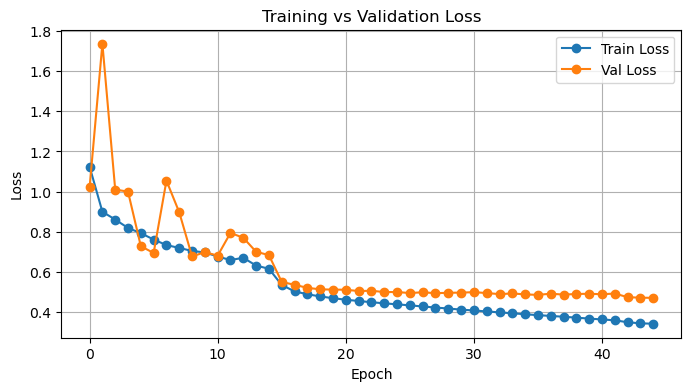

Training:   0%|          | 1/209 [00:00<00:56,  3.70it/s, avg=0.362, loss=0.362]

coords.shape = torch.Size([32, 2])


Training:   1%|          | 2/209 [00:00<00:51,  4.04it/s, avg=0.37, loss=0.377] 

coords.shape = torch.Size([32, 2])


Training:   1%|▏         | 3/209 [00:00<00:49,  4.15it/s, avg=0.339, loss=0.278]

coords.shape = torch.Size([32, 2])


Training:   2%|▏         | 4/209 [00:01<01:02,  3.27it/s, avg=0.319, loss=0.258]

coords.shape = torch.Size([32, 2])


Training:   2%|▏         | 5/209 [00:01<00:59,  3.41it/s, avg=0.312, loss=0.285]

coords.shape = torch.Size([32, 2])


Training:   3%|▎         | 6/209 [00:01<00:58,  3.46it/s, avg=0.305, loss=0.268]

coords.shape = torch.Size([32, 2])


Training:   3%|▎         | 7/209 [00:01<00:55,  3.63it/s, avg=0.294, loss=0.227]

coords.shape = torch.Size([32, 2])


Training:   4%|▍         | 8/209 [00:02<00:52,  3.81it/s, avg=0.292, loss=0.278]

coords.shape = torch.Size([32, 2])


Training:   4%|▍         | 9/209 [00:02<00:49,  4.07it/s, avg=0.31, loss=0.457] 

coords.shape = torch.Size([32, 2])


Training:   5%|▍         | 10/209 [00:02<00:47,  4.16it/s, avg=0.305, loss=0.259]

coords.shape = torch.Size([32, 2])


Training:   5%|▌         | 11/209 [00:02<00:46,  4.28it/s, avg=0.305, loss=0.301]

coords.shape = torch.Size([32, 2])


Training:   6%|▌         | 12/209 [00:03<00:44,  4.45it/s, avg=0.332, loss=0.636]

coords.shape = torch.Size([32, 2])


Training:   6%|▌         | 13/209 [00:03<00:43,  4.50it/s, avg=0.324, loss=0.225]

coords.shape = torch.Size([32, 2])


Training:   7%|▋         | 14/209 [00:03<00:55,  3.52it/s, avg=0.327, loss=0.362]

coords.shape = torch.Size([32, 2])


Training:   7%|▋         | 15/209 [00:03<00:51,  3.75it/s, avg=0.317, loss=0.182]

coords.shape = torch.Size([32, 2])


Training:   8%|▊         | 16/209 [00:04<00:48,  4.01it/s, avg=0.33, loss=0.52]  

coords.shape = torch.Size([32, 2])


Training:   8%|▊         | 17/209 [00:04<00:46,  4.17it/s, avg=0.334, loss=0.399]

coords.shape = torch.Size([32, 2])


Training:   9%|▊         | 18/209 [00:04<00:44,  4.29it/s, avg=0.353, loss=0.671]

coords.shape = torch.Size([32, 2])


Training:   9%|▉         | 19/209 [00:04<00:43,  4.36it/s, avg=0.356, loss=0.419]

coords.shape = torch.Size([32, 2])


Training:  10%|▉         | 20/209 [00:04<00:42,  4.47it/s, avg=0.354, loss=0.322]

coords.shape = torch.Size([32, 2])


Training:  10%|█         | 21/209 [00:05<00:41,  4.48it/s, avg=0.348, loss=0.212]

coords.shape = torch.Size([32, 2])


Training:  11%|█         | 22/209 [00:05<00:42,  4.44it/s, avg=0.34, loss=0.19]  

coords.shape = torch.Size([32, 2])


Training:  11%|█         | 23/209 [00:05<00:45,  4.11it/s, avg=0.338, loss=0.286]

coords.shape = torch.Size([32, 2])


Training:  11%|█▏        | 24/209 [00:05<00:43,  4.21it/s, avg=0.332, loss=0.197]

coords.shape = torch.Size([32, 2])


Training:  12%|█▏        | 25/209 [00:06<00:42,  4.29it/s, avg=0.333, loss=0.346]

coords.shape = torch.Size([32, 2])


Training:  12%|█▏        | 26/209 [00:06<00:42,  4.31it/s, avg=0.342, loss=0.572]

coords.shape = torch.Size([32, 2])


Training:  13%|█▎        | 27/209 [00:06<00:40,  4.45it/s, avg=0.338, loss=0.245]

coords.shape = torch.Size([32, 2])


Training:  13%|█▎        | 28/209 [00:06<00:43,  4.17it/s, avg=0.345, loss=0.525]

coords.shape = torch.Size([32, 2])


Training:  14%|█▍        | 29/209 [00:07<00:41,  4.34it/s, avg=0.342, loss=0.262]

coords.shape = torch.Size([32, 2])


Training:  14%|█▍        | 30/209 [00:07<00:41,  4.36it/s, avg=0.335, loss=0.137]

coords.shape = torch.Size([32, 2])


Training:  15%|█▍        | 31/209 [00:07<00:40,  4.42it/s, avg=0.332, loss=0.243]

coords.shape = torch.Size([32, 2])
coords.shape = torch.Size([32, 2])


Training:  16%|█▌        | 33/209 [00:08<00:44,  3.95it/s, avg=0.328, loss=0.294]

coords.shape = torch.Size([32, 2])


Training:  16%|█▋        | 34/209 [00:08<00:42,  4.08it/s, avg=0.334, loss=0.511]

coords.shape = torch.Size([32, 2])


Training:  17%|█▋        | 35/209 [00:08<00:41,  4.23it/s, avg=0.333, loss=0.3]  

coords.shape = torch.Size([32, 2])


Training:  17%|█▋        | 36/209 [00:08<00:39,  4.34it/s, avg=0.342, loss=0.658]

coords.shape = torch.Size([32, 2])


Training:  18%|█▊        | 37/209 [00:08<00:39,  4.34it/s, avg=0.34, loss=0.281] 

coords.shape = torch.Size([32, 2])


Training:  18%|█▊        | 38/209 [00:09<00:38,  4.41it/s, avg=0.344, loss=0.501]

coords.shape = torch.Size([32, 2])


Training:  19%|█▊        | 39/209 [00:09<00:45,  3.77it/s, avg=0.343, loss=0.302]

coords.shape = torch.Size([32, 2])


Training:  19%|█▉        | 40/209 [00:09<00:41,  4.04it/s, avg=0.344, loss=0.361]

coords.shape = torch.Size([32, 2])


Training:  20%|█▉        | 41/209 [00:09<00:39,  4.25it/s, avg=0.345, loss=0.382]

coords.shape = torch.Size([32, 2])


Training:  20%|██        | 42/209 [00:10<00:41,  4.01it/s, avg=0.348, loss=0.471]

coords.shape = torch.Size([32, 2])


Training:  21%|██        | 43/209 [00:10<00:42,  3.90it/s, avg=0.345, loss=0.245]

coords.shape = torch.Size([32, 2])


Training:  21%|██        | 44/209 [00:10<00:41,  3.99it/s, avg=0.345, loss=0.324]

coords.shape = torch.Size([32, 2])


Training:  22%|██▏       | 45/209 [00:10<00:39,  4.15it/s, avg=0.343, loss=0.246]

coords.shape = torch.Size([32, 2])


Training:  22%|██▏       | 46/209 [00:11<00:38,  4.18it/s, avg=0.343, loss=0.383]

coords.shape = torch.Size([32, 2])


Training:  22%|██▏       | 47/209 [00:11<00:37,  4.38it/s, avg=0.344, loss=0.352]

coords.shape = torch.Size([32, 2])


Training:  23%|██▎       | 48/209 [00:11<00:38,  4.13it/s, avg=0.342, loss=0.261]

coords.shape = torch.Size([32, 2])


Training:  23%|██▎       | 49/209 [00:11<00:38,  4.21it/s, avg=0.338, loss=0.168]

coords.shape = torch.Size([32, 2])


Training:  24%|██▍       | 50/209 [00:12<00:37,  4.26it/s, avg=0.34, loss=0.426] 

coords.shape = torch.Size([32, 2])


Training:  24%|██▍       | 51/209 [00:12<00:39,  3.98it/s, avg=0.338, loss=0.227]

coords.shape = torch.Size([32, 2])


Training:  25%|██▍       | 52/209 [00:12<00:40,  3.89it/s, avg=0.337, loss=0.314]

coords.shape = torch.Size([32, 2])


Training:  25%|██▌       | 53/209 [00:12<00:39,  3.97it/s, avg=0.337, loss=0.307]

coords.shape = torch.Size([32, 2])


Training:  26%|██▌       | 54/209 [00:13<00:38,  4.00it/s, avg=0.338, loss=0.376]

coords.shape = torch.Size([32, 2])


Training:  26%|██▋       | 55/209 [00:13<00:38,  3.96it/s, avg=0.342, loss=0.608]

coords.shape = torch.Size([32, 2])


Training:  27%|██▋       | 56/209 [00:13<00:39,  3.88it/s, avg=0.342, loss=0.291]

coords.shape = torch.Size([32, 2])


Training:  27%|██▋       | 57/209 [00:13<00:38,  3.92it/s, avg=0.342, loss=0.361]

coords.shape = torch.Size([32, 2])


Training:  28%|██▊       | 58/209 [00:14<00:38,  3.93it/s, avg=0.344, loss=0.443]

coords.shape = torch.Size([32, 2])


Training:  28%|██▊       | 59/209 [00:14<00:43,  3.48it/s, avg=0.345, loss=0.424]

coords.shape = torch.Size([32, 2])


Training:  29%|██▊       | 60/209 [00:14<00:41,  3.56it/s, avg=0.348, loss=0.529]

coords.shape = torch.Size([32, 2])


Training:  29%|██▉       | 61/209 [00:15<00:38,  3.85it/s, avg=0.346, loss=0.215]

coords.shape = torch.Size([32, 2])


Training:  30%|██▉       | 62/209 [00:15<00:36,  4.06it/s, avg=0.344, loss=0.24] 

coords.shape = torch.Size([32, 2])


Training:  30%|███       | 63/209 [00:15<00:36,  4.04it/s, avg=0.345, loss=0.383]

coords.shape = torch.Size([32, 2])


Training:  31%|███       | 64/209 [00:15<00:34,  4.17it/s, avg=0.347, loss=0.474]

coords.shape = torch.Size([32, 2])


Training:  31%|███       | 65/209 [00:15<00:33,  4.29it/s, avg=0.346, loss=0.289]

coords.shape = torch.Size([32, 2])


Training:  32%|███▏      | 66/209 [00:16<00:33,  4.33it/s, avg=0.347, loss=0.39] 

coords.shape = torch.Size([32, 2])


Training:  32%|███▏      | 67/209 [00:16<00:32,  4.42it/s, avg=0.351, loss=0.613]

coords.shape = torch.Size([32, 2])


Training:  33%|███▎      | 68/209 [00:16<00:35,  3.93it/s, avg=0.352, loss=0.436]

coords.shape = torch.Size([32, 2])


Training:  33%|███▎      | 69/209 [00:16<00:35,  3.99it/s, avg=0.354, loss=0.51] 

coords.shape = torch.Size([32, 2])


Training:  33%|███▎      | 70/209 [00:17<00:34,  4.03it/s, avg=0.352, loss=0.242]

coords.shape = torch.Size([32, 2])


Training:  34%|███▍      | 71/209 [00:17<00:33,  4.07it/s, avg=0.353, loss=0.397]

coords.shape = torch.Size([32, 2])


Training:  34%|███▍      | 72/209 [00:17<00:32,  4.16it/s, avg=0.351, loss=0.208]

coords.shape = torch.Size([32, 2])


Training:  35%|███▍      | 73/209 [00:17<00:31,  4.29it/s, avg=0.349, loss=0.179]

coords.shape = torch.Size([32, 2])


Training:  35%|███▌      | 74/209 [00:18<00:31,  4.30it/s, avg=0.349, loss=0.39] 

coords.shape = torch.Size([32, 2])


Training:  36%|███▌      | 75/209 [00:18<00:30,  4.40it/s, avg=0.351, loss=0.486]

coords.shape = torch.Size([32, 2])


Training:  36%|███▋      | 76/209 [00:18<00:31,  4.28it/s, avg=0.352, loss=0.404]

coords.shape = torch.Size([32, 2])


Training:  37%|███▋      | 77/209 [00:18<00:35,  3.73it/s, avg=0.355, loss=0.602]

coords.shape = torch.Size([32, 2])


Training:  37%|███▋      | 78/209 [00:19<00:35,  3.74it/s, avg=0.352, loss=0.151]

coords.shape = torch.Size([32, 2])


Training:  38%|███▊      | 79/209 [00:19<00:35,  3.68it/s, avg=0.351, loss=0.232]

coords.shape = torch.Size([32, 2])


Training:  38%|███▊      | 80/209 [00:19<00:36,  3.57it/s, avg=0.35, loss=0.286] 

coords.shape = torch.Size([32, 2])
coords.shape = torch.Size([32, 2])


Training:  39%|███▉      | 82/209 [00:20<00:45,  2.78it/s, avg=0.347, loss=0.121]

In [ ]:
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# 🔧 設定裝置
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 🔧 初始化模型 & 優化器
model = VisionMLPModelWithCoord().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=10)

# 🔧 儲存 log 的設定
log_file = open("training_log.csv", mode="w", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Spearman", "Learning Rate"])

# 🔧 用來畫圖
train_losses = []
val_losses = []


# 🔁 開始訓練
num_epochs = 150
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_spearman = evaluate(model, val_loader, loss_fn, device)

    # ✅ 儲存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved best model!")

    # ✅ 調整學習率
    scheduler.step(val_loss)

    # ✅ 寫入 CSV log
    lr = optimizer.param_groups[0]['lr']
    csv_writer.writerow([epoch+1, train_loss, val_loss, val_spearman, lr])

    # ✅ 印 epoch 結果
    print(f"Epoch {epoch+1}/{num_epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | ρ: {val_spearman:.4f} | lr: {lr:.2e}")

    # ✅ 更新 loss list 並畫圖
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    plot_losses(train_losses, val_losses)

    # ✅ Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered.")
        break

# ✅ 關閉 log 檔案
log_file.close()


In [46]:
val_loss, val_spearman = evaluate(model, val_loader, loss_fn, device)
print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val ρ: {val_spearman:.4f}")


[Epoch 14] Train Loss: 0.1011 | Val Loss: 1.4347 | Val ρ: 0.2025


In [14]:
batch = next(iter(train_loader))

for i, meta in enumerate(batch['meta']):
    print(f"[{i}] meta =", meta, "| type:", type(meta))


[0] meta = tensor([ 1.3875,  1.9003, -0.2545,  2.1308,  0.4801, -0.3525, -1.1850, -0.1594,
        -0.5051,  1.0562, -0.6578,  1.4250, -0.2660, -1.9859, -0.0529,  1.6900,
        -1.8476, -0.0442,  1.1052,  0.1430,  0.6501, -0.4850, -0.6319, -0.1422,
        -0.7097, -0.8537, -0.4907, -0.5599,  1.4970, -0.4302,  0.2496,  1.4480],
       dtype=torch.float64) | type: <class 'torch.Tensor'>
[1] meta = tensor([-0.9916, -0.6412, -0.2611,  1.1767, -2.0526, -0.5619, -0.7932,  1.2594,
        -0.9949,  0.3107,  0.6710,  0.8991, -1.1535, -0.0132,  0.2149,  0.2182,
        -0.2082, -2.0360,  2.3105, -0.6709,  0.0893, -0.5685, -1.5964,  0.7206,
        -0.7172, -0.8626,  1.0412, -1.1535, -1.5931, -0.5420, -0.4230, -0.1851],
       dtype=torch.float64) | type: <class 'torch.Tensor'>


In [ ]:
model = HEVisumModel().to(device)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
